In [22]:
import csv
nazwa_pliku = '/content/drive/MyDrive/jena_climate_2009_2016.csv'
with open(nazwa_pliku, 'r') as plik:
    data = plik.read()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [23]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values
print(float_data.shape)

(420451, 14)


52556


Text(0.5, 0, 'time')

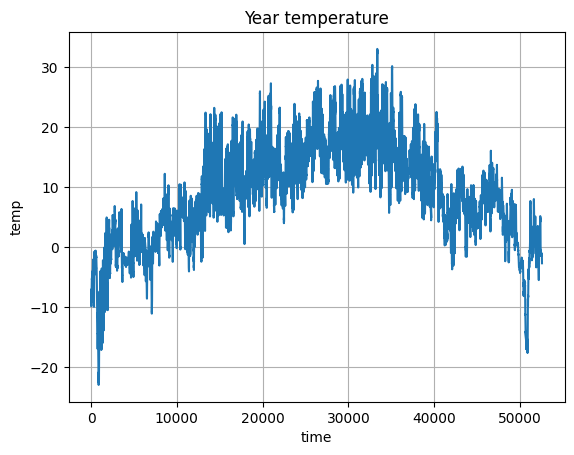

In [24]:
import matplotlib.pyplot as plt

temp = float_data[:, 1]
temp_year = int(float_data.shape[0]/8)
print(temp_year)
plt.plot(temp[:temp_year])
plt.grid()
plt.title("Year temperature")
plt.ylabel("temp")
plt.xlabel("time")

ilość pomiarów jednego dnia 143


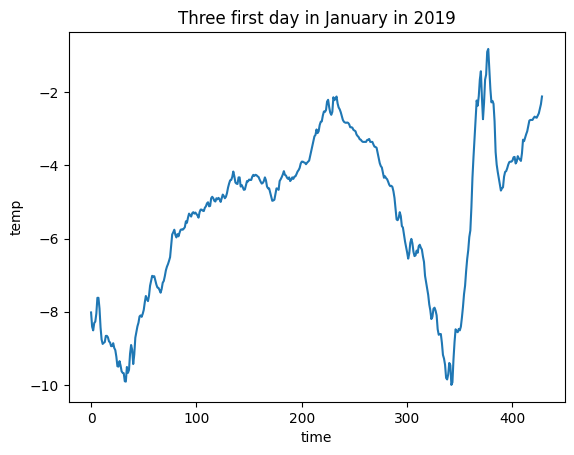

In [25]:
temp_day = int(temp_year/365)
print("ilość pomiarów jednego dnia", temp_day)
plt.plot(temp[:temp_day*3])
plt.title("Three first day in January in 2019")
plt.ylabel("temp")
plt.xlabel("time")
plt.show()

In [26]:
# Normalization temperatury

# temp_ = temp[:200000]
# mean_temp = np.mean(temp_)
# # print(mean_temp)
# std_temp = np.std(temp_)
# float_data = (float_data - mean_temp)/std_temp
# # temp_ = (temp_ - np.min(temp_))/(np.max(temp_) - np.min(temp_))
# plt.plot(temp_)
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std


In [27]:
# data_norm = float_data[:200000]
# mean_data_norm = np.mean(data_norm, axis=0)
# std_data_norm = np.std(data_norm, axis=0)
# data_norm = (data_norm - mean_data_norm)/std_data_norm
# data_norm = (data_norm - np.min(data_norm, axis=0))/(np.max(data_norm,axis=0) - np.min(data_norm,axis=0))
# plt.plot(data_norm[:,1])


In [28]:
# data_norm1 = float_data[200001:300000]
# mean_data_norm1 = np.mean(data_norm1, axis=0)
# std_data_norm1 = np.std(data_norm1, axis=0)
# data_norm1 = (data_norm1 - mean_data_norm1)/std_data_norm1
# data_norm1 = (data_norm1 - np.min(data_norm1, axis=0))/(np.max(data_norm1,axis=0) - np.min(data_norm1,axis=0))
# plt.plot(data_norm1[:,1])

In [29]:
# data_norm2 = float_data[300001:400000]
# mean_data_norm2 = np.mean(data_norm2, axis=0)
# std_data_norm2 = np.std(data_norm2, axis=0)
# data_norm2 = (data_norm2 - mean_data_norm2)/std_data_norm2
# data_norm2 = (data_norm2 - np.min(data_norm2, axis=0))/(np.max(data_norm2,axis=0) - np.min(data_norm2,axis=0))
# plt.plot(data_norm2[:,1])

In [30]:
# float_data[:200000] = data_norm
# float_data[200001:300000] = data_norm1
# float_data[300001:400000] = data_norm2
# plt.plot(float_data[:200000,1])


In [31]:
def generator(data, lookback, delay, min_index, max_index,
                shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                    min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                            lookback // step,
                            data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [32]:
batch_size= 128
lookback = 1440
step=6
delay=144

train_gen = generator(float_data,
                        lookback=lookback,
                        delay=delay,
                        min_index=0,
                        max_index=200000,
                        shuffle=True,
                        step=step,
                        batch_size=batch_size)

val_gen = generator(float_data,
                        lookback=lookback,
                        delay=delay,
                        min_index=200000,
                        max_index=300000,
                        shuffle=False,
                        step=step,
                        batch_size=batch_size)


test_gen = generator(float_data,
                        lookback=lookback,
                        delay=delay,
                        min_index=300000,
                        max_index=None,
                        shuffle=False,
                        step=step,
                        batch_size=batch_size)

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Embedding, SimpleRNN, Dense, GRU
from keras.optimizers import RMSprop


model = Sequential()
model.add(Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

# Number of steps to draw from val_gen to see the entire validation sete
val_steps = (300000 - 200001 - lookback)//batch_size
test_steps = (len(float_data) - 300001 - lookback)  // batch_size

#TODO: Train the network for about 20 epochs
history = model.fit_generator(train_gen, epochs= 20, steps_per_epoch = 500, validation_steps = val_steps, validation_data = val_gen)
#TODO: Plot the results

Epoch 1/20


<ipython-input-33-df66384f2b8c>:18: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen, epochs= 20, steps_per_epoch = 500, validation_steps = val_steps, validation_data = val_gen)


500/500 [==============================] - 18s 35ms/step - loss: 1.3165 - val_loss: 0.7229
Epoch 2/20
500/500 [==============================] - 12s 25ms/step - loss: 0.4310 - val_loss: 0.3623
Epoch 3/20
500/500 [==============================] - 17s 34ms/step - loss: 0.2912 - val_loss: 0.3355
Epoch 4/20
500/500 [==============================] - 12s 25ms/step - loss: 0.2665 - val_loss: 0.3195
Epoch 5/20
500/500 [==============================] - 13s 27ms/step - loss: 0.2526 - val_loss: 0.3418
Epoch 6/20
500/500 [==============================] - 14s 28ms/step - loss: 0.2452 - val_loss: 0.3294
Epoch 7/20
500/500 [==============================] - 25s 51ms/step - loss: 0.2380 - val_loss: 0.3899
Epoch 8/20
500/500 [==============================] - 24s 47ms/step - loss: 0.2308 - val_loss: 0.3786
Epoch 9/20
500/500 [==============================] - 15s 29ms/step - loss: 0.2262 - val_loss: 0.3250
Epoch 10/20
500/500 [==============================] - 23s 46ms/step - loss: 0.2213 - val_los

In [34]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'val_loss'])

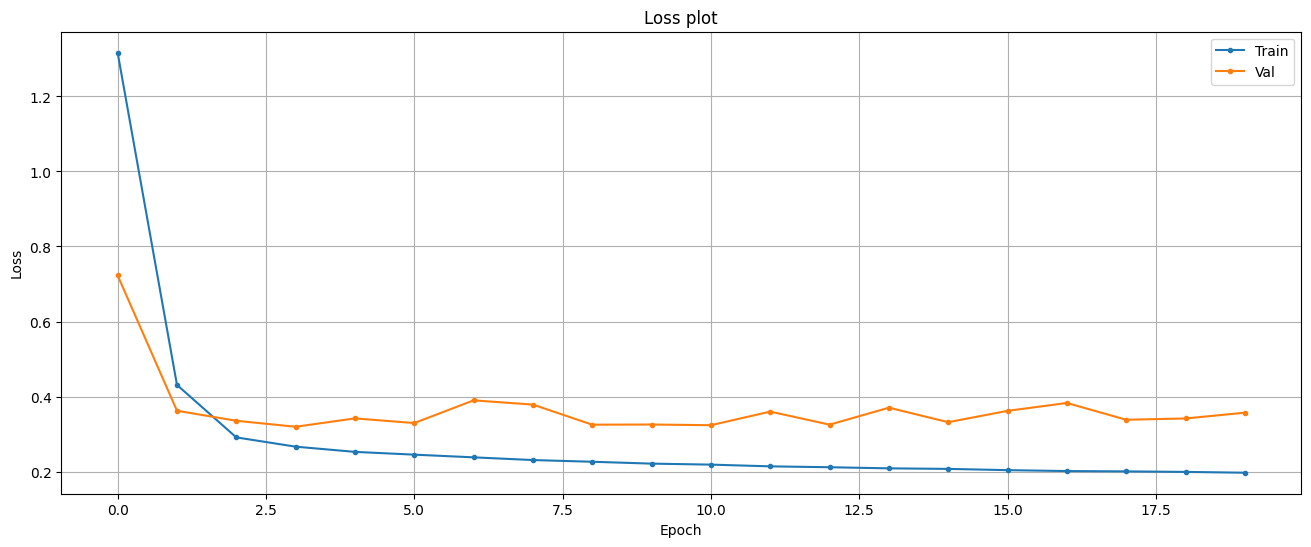

In [35]:
import matplotlib.pyplot as plt
plt.figure(figsize = (16,6))
plt.plot(history_dict['loss'],".-")
plt.plot(history_dict['val_loss'],".-")
plt.title("Loss plot")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Val"])
plt.grid()


In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Embedding, SimpleRNN, Dense, GRU

model1 = Sequential()
model1.add(GRU(32, input_shape=(None, float_data.shape[-1])))
model1.add(Dense(1))
model1.compile(optimizer="rmsprop", loss='mae')

history1 = model1.fit(train_gen, epochs= 40, steps_per_epoch = 200, batch_size= 128, validation_steps = val_steps, validation_data = val_gen)

Exception ignored in: <function _xla_gc_callback at 0x7a2176b75ea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 97, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


Epoch 1/40
200/200 [==============================] - 15s 68ms/step - loss: 0.3554 - val_loss: 0.2840
Epoch 2/40
200/200 [==============================] - 12s 59ms/step - loss: 0.2957 - val_loss: 0.2739
Epoch 3/40
200/200 [==============================] - 13s 65ms/step - loss: 0.2937 - val_loss: 0.2841
Epoch 4/40
200/200 [==============================] - 10s 50ms/step - loss: 0.2885 - val_loss: 0.2688
Epoch 5/40
200/200 [==============================] - 11s 57ms/step - loss: 0.2844 - val_loss: 0.2688
Epoch 6/40
200/200 [==============================] - 12s 59ms/step - loss: 0.2808 - val_loss: 0.2683
Epoch 7/40
200/200 [==============================] - 13s 65ms/step - loss: 0.2790 - val_loss: 0.2700
Epoch 8/40
200/200 [==============================] - 12s 58ms/step - loss: 0.2779 - val_loss: 0.2710
Epoch 9/40
200/200 [==============================] - 13s 67ms/step - loss: 0.2769 - val_loss: 0.2663
Epoch 10/40
200/200 [==============================] - 13s 66ms/step - loss: 0.275

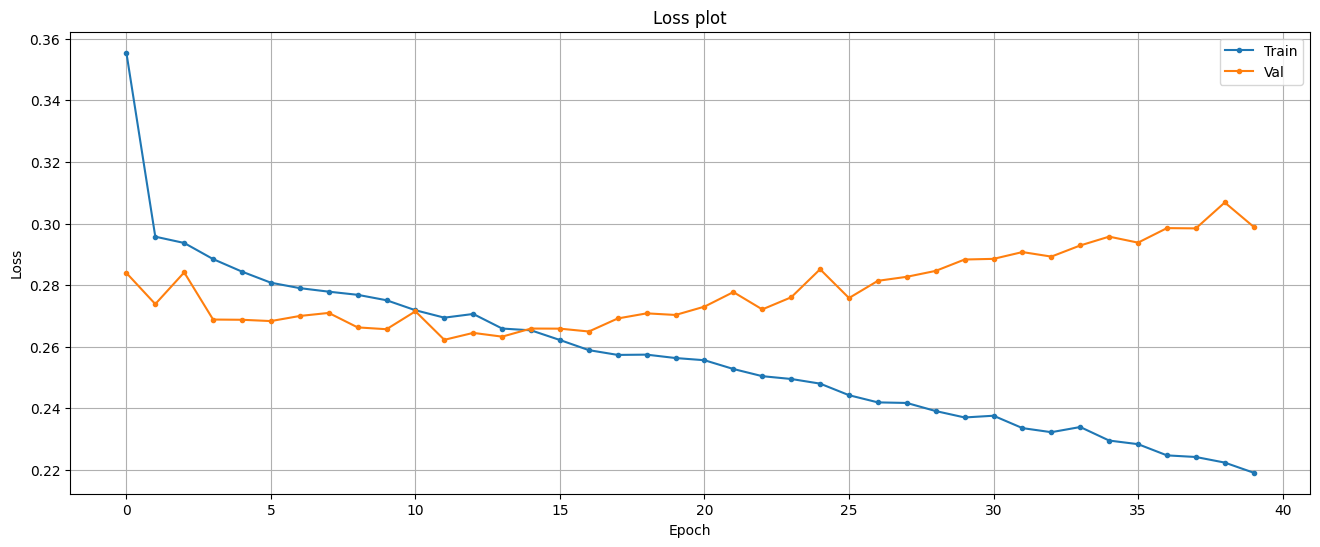

In [37]:
history_dict = history1.history
history_dict.keys()
import matplotlib.pyplot as plt
plt.figure(figsize = (16,6))
plt.plot(history_dict['loss'],".-")
plt.plot(history_dict['val_loss'],".-")
plt.title("Loss plot")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Val"])
plt.grid()

In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Embedding, SimpleRNN, Dense, GRU

model3 = Sequential()
model3.add(GRU(32,dropout=0.2,recurrent_dropout=0.2,input_shape=(None, float_data.shape[-1])))
model3.add(Dense(1))
model3.compile(optimizer="rmsprop", loss='mae')

history3 = model3.fit(train_gen, epochs= 20, steps_per_epoch = 500, batch_size= 128, validation_steps = val_steps, validation_data = val_gen)

Epoch 1/20
172/500 [=========>....................] - ETA: 3:16 - loss: 0.3431

KeyboardInterrupt: 

In [ ]:
history_dict = history3.history
history_dict.keys()
import matplotlib.pyplot as plt
plt.figure(figsize = (16,6))
plt.plot(history_dict['loss'],".-")
plt.plot(history_dict['val_loss'],".-")
plt.title("Loss plot")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Val"])
plt.grid()

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Embedding, SimpleRNN, Dense, GRU, Conv1D, MaxPooling1D
model4 = Sequential()
model4.add(Conv1D(32, 5, activation='relu',
        input_shape=(None, float_data.shape[-1])))
model4.add(MaxPooling1D(3))
model4.add(Conv1D(32, 5, activation='relu'))
model4.add(GRU(32, dropout=0.1, recurrent_dropout=0.5))
model4.add(Dense(1))
model4.compile(optimizer="rmsprop", loss='mae')
history4 = model4.fit(train_gen, epochs= 20, steps_per_epoch = 200, batch_size= 128, validation_steps = val_steps, validation_data = val_gen)

Epoch 1/20
200/200 [==============================] - 72s 339ms/step - loss: 0.3690 - val_loss: 0.3186
Epoch 2/20
200/200 [==============================] - 68s 339ms/step - loss: 0.3279 - val_loss: 0.3318
Epoch 3/20
200/200 [==============================] - 69s 346ms/step - loss: 0.3166 - val_loss: 0.3116
Epoch 4/20
200/200 [==============================] - 67s 334ms/step - loss: 0.3079 - val_loss: 0.3022
Epoch 5/20
200/200 [==============================] - 68s 343ms/step - loss: 0.2976 - val_loss: 0.3283
Epoch 6/20
200/200 [==============================] - 67s 334ms/step - loss: 0.2953 - val_loss: 0.2928
Epoch 7/20
200/200 [==============================] - 69s 347ms/step - loss: 0.2917 - val_loss: 0.2925
Epoch 8/20
200/200 [==============================] - 68s 340ms/step - loss: 0.2840 - val_loss: 0.2932
Epoch 9/20
200/200 [==============================] - 69s 344ms/step - loss: 0.2797 - val_loss: 0.2895
Epoch 10/20
200/200 [==============================] - 69s 343ms/step - l

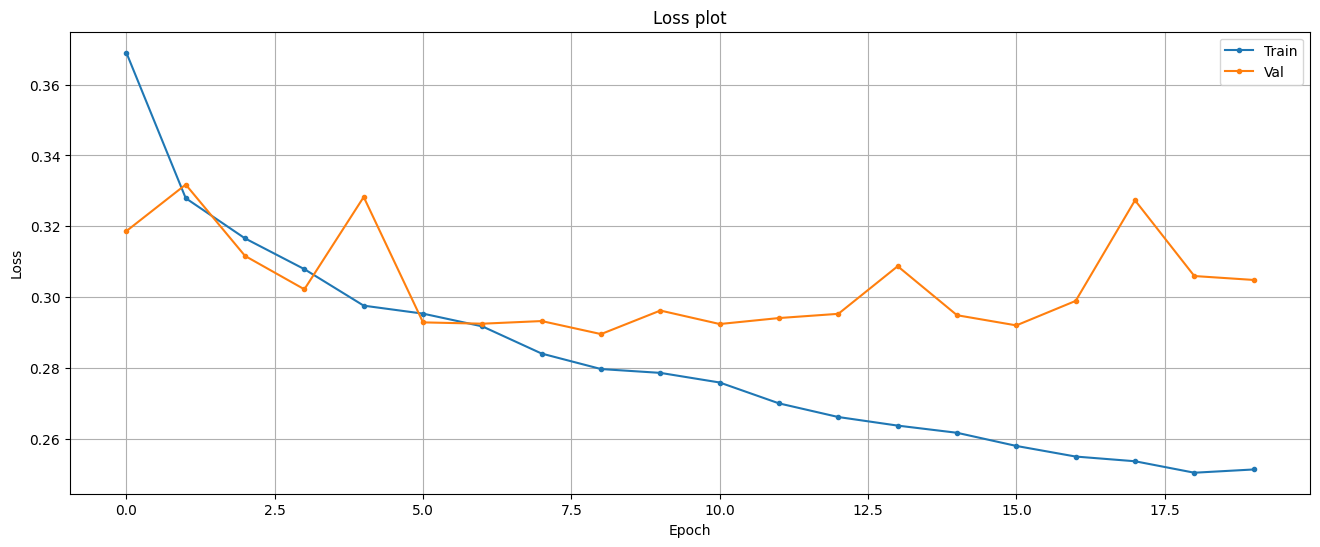

In [42]:
history_dict = history4.history
history_dict.keys()
import matplotlib.pyplot as plt
plt.figure(figsize = (16,6))
plt.plot(history_dict['loss'],".-")
plt.plot(history_dict['val_loss'],".-")
plt.title("Loss plot")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Val"])
plt.grid()